In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

In [2]:
import sys,os
import copy

In [3]:
def Numerov(Delta, StartI, EndI, MaxSol, FArr,\
            Sing, PhiStart, PhiNext):
    '''
    This is a stand-alone subroutine. So it can be defined previously.
    C Integrates the Schrodinger equation. The initial values
    C of the solution are PhiStart and PhiNext resectively. The integration
    C step is Delta, and the integration steps run from StartI to EndI. StartI may be larger
    C than EndI; in that case, integration is performed backward.
    C The output values is the solution, stored in the array "Solution".
    C Sing determines whether the potential contains a singularity at
    C r=0.
    C If there is a singularity at r=0, the value of the Numerov
    C function w at r=0 is taken equal to PhiStart, and not
    C equal to PhiStart/(1-h^2 FArr/12).
    
    C This array is declared with linear size MaxSol.
    C Delta is the integration step.
    C The equation solved is
    C Psi''(R_I) = FArr(I) Psi(R_I)
    C FArr must therefore be filled with the appropriate values before
    C calling the present routine. In the case of the radial
    C Schrodinger equation, FArr would contain the values
    C FArr(I) = 
    '''
    Solution = np.zeros(MaxSol)
    ## print("MaxSol in Numerov: ", MaxSol)
    if (Delta<0):
        IStep = -1
    else:
        IStep = 1

    DeltaSq = Delta*Delta
    Fac = DeltaSq/12.0E0

    if (Sing):
        WPrev = PhiStart
    else:
        WPrev = (1.0-Fac*FArr[StartI-1])*PhiStart
        Solution[StartI-1] = PhiStart

    # print("StartI: ", StartI)
    # print("WPrev: ", WPrev)
    # print("IStep: ", IStep)
    Phi = PhiNext
    Solution[StartI+IStep-1] = PhiNext
    W   = (1-Fac*FArr[StartI+IStep])*Phi

    N_start = StartI+IStep-1
    N_final = EndI - IStep
    ## print("Nstart, Nfinal: ",N_start,N_final)
    for I in range(N_start, N_final, IStep):
        WNext = W*2.0E0 - WPrev + DeltaSq*Phi*FArr[I]
        WPrev = W
        W     = WNext
        Phi   = W/(1.0E0-Fac*FArr[I+IStep])
        ## print("I+IStep: ",I+IStep)
        Solution[I+IStep] = Phi
        
    return Solution

def CalcInt (Array, MaxI, h):
    '''
    Calculate an integral over the radial coordinate grid. A fourth-order
    integration method is used.
    '''
    Help = (Array[0]*17.0E0+Array[1]*59.0E0+\
            Array[2]*43.0E0+Array[3]*49.0E0)/48.0E0
    for i in range(4,MaxI-4):
        Help = Help + Array[i]

    Help = (Array[MaxI-1]*17.0E0+Array[MaxI-2]*59.0E0+\
            Array[MaxI-3]*43.0E0+Array[MaxI-4]*49.0E0)/48.0E0+\
            Help
    Result = Help * h
    return Result

def NumInhom (Delta, L, StartR, MaxR, ZeroSing, PhiStart, PhiNext, RHS, MaxSol):
    '''
    Integrates an inhomogeneous the Schrodinger equation from ‘StartR’ to ‘MaxR’. 
    The initial values of the solution are PhiStart and PhiNext resectively.
    MaxR is also output as the value nearest to MaxR which is an integer
    C times the integration step from StartR.
    The output value is the solution, stored in the array "Solution".
    C This array is declared with linear size MaxSol.
    C Delta is the integration step. L is the angular momentum quantum number,
    C which is passed to the function F(R,L,E) which returns
    C F(R,L) = V(R)-E+h^2 L(L+1)/(2MR^2)
    '''

    Solution = np.zeros(MaxSol)
    
    MaxI = np.int((MaxR-StartR)/Delta)
    
    
    if (MaxSol<MaxI):
        print(MaxI, ' integration points')
        print('Size of array Solution not large enough')
        print('Program stopped in routine Numerov')
        sys.exit()
        
    DeltaSq = Delta*Delta
    Fac = DeltaSq/12.0E0

    R  = StartR
    if (ZeroSing):
        WPrev = PhiStart
        Solution[0] = 0.0E0
    else:
        WPrev = PhiStart-Fac*RHS[0] ### In stream, RHS[0] = ChDens[0]
        Solution[0] = PhiStart


    R  = StartR+Delta
    Phi = PhiNext
    Solution[1] = PhiNext
    W   = Phi-Fac*RHS[1]
    # print("W in NumInhom: %12.6f" % (W))
    #   DO I = 2, MaxI+1
    for i in range(1, MaxI+1):
        #print(rhs[i])
        WNext = W*2.0E0 - WPrev + DeltaSq*RHS[i]
        WPrev = W
        W     = WNext
        R = R + Delta
        Phi   = W+Fac*RHS[i+1]
        Solution[i+1] = Phi
        # print("%8d RHS, WNext and Phi in NumInhom: %12.6f %12.6f | %12.6f" % (i+1, RHS[i], WNext, Phi))
    MaxR = R-Delta
    PhiRNext = Phi
    PhiRMax = WPrev+Fac*RHS[MaxI]
    
    return Solution #, MaxR, PhiRNext, PhiRMax

```Fortran
DO WHILE(ABS(OldEnergy-Energy).GT.Precision)
         OldEnergy = Energy
         CALL FindBound(Energy, Precision)
         CALL SolveRad(Energy)
         CALL HartCorrect
         CALL ExcCorrect
         CALL CorrCorrect
         print *, 'Eigenvalue', Energy
         print *, 'total energy',2*Energy-HartCorr+ExcCorr+CorrCorr
         CALL CalcHartPot
         CALL CalcExcPot
         CALL CalcCorrPot
       END DO
```

In [13]:
def FillFArr(Energy,MaxSol,MaxI,h,Z,HartPot,Vx,Vc):
    '''
    C Fills the array FArr, appearing in the radial equation
    C Phi'' = F Phi with the appropriate values.
    '''
    FArr = np.zeros(MaxSol)

    for I in range(1,MaxI,1):
        r = I*h
        FArr[I] = -2.0E0*(Energy+(Z-HartPot[I])/r-Vx[I]-Vc[I])
    
    return FArr

def PhiMax(Energy,MaxRad,MaxSol,MaxI,h,Z,HartPot,Vx,Vc):
    '''
    PhiMax returns the value of u(r) = rR(r) at the nucleus, r=0: 
    u(r=0)
    This is used in subroutine FindBound to find the bound states.
    '''
    FArr = FillFArr(Energy,MaxSol,MaxI,h,Z,HartPot,Vx,Vc)
    
    PhiStart = MaxRad*np.exp(-Z*MaxRad)
    R = MaxRad-h
    PhiNext = R*np.exp(-Z*R)
    
    RadArr = Numerov (-h, MaxI, 0, MaxSol, FArr, False, PhiStart,PhiNext)
    RadArr[0] = 2*RadArr[1]-RadArr[2]+h*h*FArr[1]*RadArr[1]
    PhiMax = RadArr[0]
    
    return PhiMax

def FindBound(Precision,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc):
    '''
    C Find the energy of the bound state.
    C The bound state is characterised as having a zero at r=0
    '''

    Low = -3.0E0
    Step = 0.10E0 ### Step is fixed.
    Low_new = FindStep(Low, Step, PhiMax,\
                       MaxRad,MaxSol,MaxI,h,Z,HartPot,Vx,Vc)
    Low = Low_new
# Search for change of sign
    High = Low+Step
    
    NewPrec = Precision*0.10E0
# Find root by interpolation
    Energy = Interpolate (Low, High, NewPrec, PhiMax,
                         MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)

    return Energy

###
def FindStep (MinX, Step, PhiMax,MaxRad,MaxSol,MaxI,h,Z,HartPot,Vx,Vc):
    '''
    F here is an object, a function.
    '''
    FPrev = PhiMax(MinX, MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)
    FNext = PhiMax(MinX + Step,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)
    while (FNext*FPrev > 0):
        MinX = MinX + Step
        FNext = PhiMax(MinX+Step,MaxRad,MaxSol, MaxI, h, Z, HartPot,Vx,Vc)
    return MinX


def Interpolate (MinX, MaxX, IntWidth, PhiMax,\
                 MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc):
    LeftX    = MinX
    RightX   = MaxX
    LeftRes  = PhiMax(MinX,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)
    RightRes = PhiMax(MaxX,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)
    MidRes = 1.0E0

    jj = 0
    while (np.abs(MidRes)> IntWidth):
        jj += 1
        MidX = (RightX*LeftRes-LeftX*RightRes)/(LeftRes-RightRes)
        MidRes = PhiMax(MidX,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)

        if (MidRes*LeftRes>0.0):
            LeftRes = MidRes
            LeftX = MidX
        else:
            RightRes = MidRes
            RightX = MidX
        if jj > 100:
            print("jj is larger than 100!")
            sys.exit()
    IntX = MidX
    return IntX

In [16]:
## For test.
##Energy = FindBound(Precision,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)

# Exchange part
$$\begin{aligned}\int {\rm{d}}r\, u^2(r) = \int {\rm{d}}r\, r^2 R^2(r) = 1\end{aligned}$$

$$\begin{aligned}
n(r) = R^2(r) = \frac{u^2(r)}{r^2}\\
\end{aligned}$$

From jellium model of free electron gas in solid (Ashcroft & Mermin, pp. 334), we have:
$$\begin{aligned}
E_{\rm{X}} & = -\frac{3}{4\pi}k_{\rm{F}}N \\
k_{\rm{F}} & = \left[3\pi^2 n(r)\right]^{1/3} \\
N & = \frac{8\pi \Omega k^3_{\rm{F}}}{3(2\pi)^3} = \frac{\Omega k^3_{\rm{F}}}{3\pi^2}\\
& \Rightarrow \\
\frac{E_{\rm{X}}}{\Omega} &  = - \frac{3}{4\pi} \left[3\pi^2 n(r)\right]^{1/3} \frac{ 3\pi^2 n(r)}{3\pi^2} \\
E_{V,\rm{X}} \equiv \frac{E_{\rm{X}}}{\Omega} &  = - \frac{3}{4}\left[\frac{3}{\pi}\right]^{1/3} n^{4/3}(r) \\
& \Rightarrow \\
V_{\rm{X}} & = \frac{\delta E_{V,\rm{X}}}{\delta n(r)} = -\left[\frac{3}{\pi}\right]^{1/3} n^{1/3}(r) \\
\end{aligned}$$




$$\begin{aligned}
V_{\rm{X}}(\boldsymbol{r}) & = -\left[
\frac{3}{\pi} n(\boldsymbol{r})
\right]^{1/3} \\
\end{aligned}$$

$$\begin{aligned}
{\rm{ChDens}} & = -4\pi r n(r) \\
& \Rightarrow \\
V_{\rm{X}}(\boldsymbol{r}) & = -\left[
\frac{3}{\pi} (-2) \frac{{\rm{ChDens}} }{4\pi r}
\right]^{1/3} \\
& = -\left[
-\frac{3}{2\pi^2}\frac{{\rm{ChDens}} }{ r}
\right]^{1/3} \\
\end{aligned}$$

# Correlation part

This part can be found in the page of 117 to 118 of J. Thijssen's Computational Physics. But there is an extra attention need to pay in the calculation of total energy. In total energy, actually we need to calculate:

$$\begin{aligned}
E_{\rm{C}}[n(r)] - \int V_{\rm{C}}[n(r)]n(r) {\rm{d}}^3r \\
\end{aligned}$$

And in Ceperly-Alder's correlation functional, we have:
$$\begin{aligned}
E_{\rm{C}}[n(r)] = \int \varepsilon_{\rm{C}}[n(r)]n(r) {\rm{d}}^3r \\
\end{aligned}$$

And also consider the density is with the expression:
$$\begin{aligned}
{\rm{ChDens}} & = -4\pi r n(r) \\
\end{aligned}$$

So at lase, the working formula is:
$$\begin{aligned}
{\rm{Correlation\, \, part\, \, of\, \, total\, \, energy}} & = 
\int (\varepsilon_{\rm{C}}[n(r)]-  V_{\rm{C}}[n(r)]) (-2 \times{\rm{ChDens}}) r{\rm{d}}r \\
\end{aligned}$$

Here $2$ means two electrons.

In [30]:
def SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z,HartPot,Vx,Vc):
    '''
    Solve the radial Schrodinger equation
    The solution is used to determine the charge density
    
    This is the 2nd major subroutine.
    '''

    FArr = FillFArr(Energy,MaxSol,MaxI,h,Z,HartPot,Vx,Vc) ## Pay attention to HartPot, Vx, and Vc!
    PhiStart = MaxRad*np.exp(-Z*MaxRad)
    R = MaxRad-h
    PhiNext = R*np.exp(-Z*R)
    
    RadArr = Numerov (-h, MaxI, 0, MaxSol, FArr, False, PhiStart,PhiNext)
    RadArr[0] = 2*RadArr[1]-RadArr[2]+h*h*FArr[1]*RadArr[1]

    
    for I in range(MaxI):
        ChDens[I] = RadArr[I]**2

    NormFac = CalcInt(ChDens, MaxI, h)

    NormFac = 1.0E0/NormFac
    ChDens[0] = 0.0E0 ## 
    
    for I in range(1,MaxI,1):
        R = I*h
        ChDens[I] = -NormFac*ChDens[I]/R
#### Note that ChDens is in fact -n(r)*r*4*pi !!
    
    return Energy, ChDens

def CalcHartPot(MaxRad,MaxSol,MaxI,h,ChDens):
    '''
    C Calculate the hartree potential. This is done by radially integrating
    C Poisson's equation. The correct boundary equations are met by starting
    C at Vh(0) = 0, and by adding the homegeneous solution alpha x r to the result
    C in order to fix the potential at MaxRad to Z/r.
    C The charge ZScr is that part of the charge of the screening
    C electron which lies in the sphere with radius
    C MaxRad (this charge must be close to 1 if MaxRad is large).
    C Note that HartPot is r x potential
    
    In major subroutine:
    Delta = h
    L = 0
    StartR = 0.0
    MaxR = MaxRad
    ZeroSing = False
    PhiStart = 0.0
    PhiNext = h
    RHS = ChDens
    MaxSol = MaxSol 
    
    Output is the array HartPot.
    '''
    HartPot = NumInhom (h, 0, 0.0E0, MaxRad, False,0.0E0,h,ChDens, MaxSol)
        
    ZScr = 1.0E0-(MaxRad*MaxRad+2*MaxRad+1.0E0)*np.exp(-MaxRad)
    Alpha = (ZScr-HartPot[MaxI])/(MaxI-1)
    
    for I in range(MaxI):
        HartPot[I] = HartPot[I]+Alpha*I
    return HartPot

def CalcExcPot(MaxSol,MaxI,h, ChDens, HartPot):
    '''
    Calculate the exchange potential. This potential is given as
    -[ 3 u^2(r) /(2 \pi^2 r^2) ]^{1/3}
    -[3 4\pi r^2 R^2(r)/ (8\pi^3 r^2)]^{1/3}
    -[3 ChDens(r)/(8\pi^3 r)]^{1/3}
    '''
    Vx = np.zeros(MaxSol)
    PI = np.pi
    Third = 1.0E0/3.0E0
    Fac = (1.50E0/(PI*PI))**Third
    Vx[0] = 0.0E0
    
    for I in range(1, MaxI, 1):
        R = I*h
        HartPot[I] = 2*HartPot[I]
        Vx[I] = -Fac*(-ChDens[I]/R)**Third
    return Vx, HartPot

def CeperAlder(Dens):
    '''
    Ceper-Alder correlation functional.
    '''
    Gamma = -0.1423E0
    Beta1 = 1.0529E0
    Beta2 = 0.3334E0
    A     = 0.0311E0
    B     = -0.048E0
    C     = 0.0020E0
    D     = -0.0116E0
    
    PI = np.pi
    Third = 1.0E0/3.0E0
    
    Rs = (0.75E0/(PI*Dens))**Third
    
    if (Rs >= 1.0E0):
        CorrEn  = Gamma/(1.0E0+Beta1*np.sqrt(Rs)+Beta2*Rs)
        
        CorrPot = CorrEn*(1.0E0+(7.0E0/6.0E0)*Beta1*np.sqrt(Rs)+\
                          (4.0E0/3.0E0)*Beta2*Rs)/(1+Beta1*np.sqrt(Rs)+Beta2*Rs)
    else:
        CorrEn  = A*np.log(Rs)+B+C*Rs*np.log(Rs)+D*Rs
        CorrPot = A*np.log(Rs)+(B-A/3.0E0)+(2/3.0E0)*C*Rs*np.log(Rs) + (2*D-C)*Rs/3.0E0
    return CorrEn, CorrPot

def CalcCorrPot(ChDens,MaxSol, MaxI,h):
    PI = np.pi
    Vc = np.zeros(MaxSol)
    Ec = np.zeros(MaxSol)
    Dens = -2*ChDens[1]/h
    CorrEn, CorrPot = CeperAlder(Dens)
    Vc[0] = CorrPot
    Ec[0] = CorrEn

    for I in range(1,MaxI,1):
        R = (I)*h
# Factor of 2 because of two electrons
        Dens = -2*ChDens[I]/(R*4*PI)
        CorrEn, CorrPot = CeperAlder(Dens)
        Vc[I] = CorrPot
        Ec[I] = CorrEn
    return Vc, Ec

def HartCorrect(HartPot, ChDens, MaxI, h):
    '''
    C Calculate 
    \int d^r r^2 V_h(r) n (r) , 
    which is needed in the calculation of the energy.
    '''
    TempArr = np.zeros(MaxI)
    for i in range(MaxI):
        TempArr[i] = - HartPot[i]*ChDens[i]

    HartCorr = CalcInt(TempArr, MaxI, h)
    
    return HartCorr

def ExcCorrect(MaxSol, MaxI, h,ChDens):
    '''
    C Calculate \int d^r r^2 V_h(r) n (r) , which is needed in the calculation
    C of the energy.    
    '''
    TempArr = np.zeros(MaxSol)
    Third   = 1.0E0/3.0E0
    PI      = np.pi

    Fac = (1.50E0/(PI*PI))**Third
    FourThirds = 4*Third
    
    for I in range(1,MaxI,1):
        R = (I)*h
        TempArr[I] = 0.5E0*Fac*(-ChDens[I]/R)**FourThirds*R*R

    ExcCorr = CalcInt(TempArr, MaxI, h)
    
    return ExcCorr

def CorrCorrect(MaxSol,MaxI,h,ChDens,Vc,Ec):
    '''
    C Calculate \int d^r r^2 V_c(r) n (r) , which is needed in the calculation
    C of the energy.
    '''
    TempArr = np.zeros(MaxSol)

    for I in range(1,MaxI,1):
        R = (I)*h
        TempArr[I] = -(Ec[I]-Vc[I])*2*ChDens[I]*R ### This expression is from (5.21) and (5.23) 
                                                  ### in J. Thijssen's book.

    CorrCorr = CalcInt(TempArr, MaxI, h)
    
    return CorrCorr
        

Eigenvalue -1.9999995967451258
total energy -3.6426159097177426
Finish a loop.
Eigenvalue -0.3787130005069845
total energy -2.5686400413478596
Finish a loop.
Eigenvalue -0.6665880442740202
total energy -2.9418231890412
Finish a loop.
Eigenvalue -0.531868014845036
total energy -2.787135193068548
Finish a loop.
Eigenvalue -0.5870260234485284
total energy -2.8541394645177127
Finish a loop.
Eigenvalue -0.5627488375172306
total energy -2.8253284478097647
Finish a loop.
Eigenvalue -0.5731216881310649
total energy -2.8377503718767407
Finish a loop.
Eigenvalue -0.5686084828806325
total energy -2.8323258299326484
Finish a loop.
Eigenvalue -0.5705757310623756
total energy -2.8346973253273284
Finish a loop.
Eigenvalue -0.5697149157471205
total energy -2.833660843875886
Finish a loop.
Eigenvalue -0.5700911753342253
total energy -2.8341141203118574
Finish a loop.
Eigenvalue -0.5699266340347998
total energy -2.8339159437175225
Finish a loop.
Eigenvalue -0.5699985740007062
total energy -2.83400259810

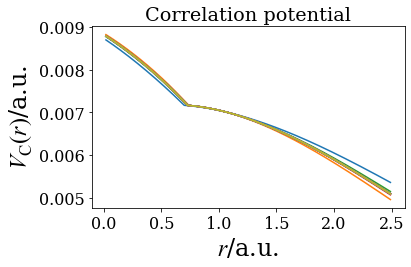

In [37]:
h = 0.01
MaxRad = 10.0
Z = 2.0E0
MaxI = np.int(MaxRad/h)
MaxRad = MaxI*h

OldEnergy = -1.0E3
Energy = -0.3E0

Precision = 1.0E-7
MaxSol = 10000

ChDens = np.zeros(MaxSol)
HartPot = np.zeros(MaxSol)
Vx      = np.zeros(MaxSol)
Vc      = np.zeros(MaxSol)
Ec      = np.zeros(MaxSol)

HartCorr = 0.0E0
ExcCorr  = 0.0E0
CorrCorr = 0.0E0

x_forplot = np.arange(0.0,MaxI*h,h)
ene_traj = []
MaxI_forplot = np.int(MaxI/4)

for kk in range(20):
    OldEnergy      = Energy
    Energy         = FindBound(Precision,MaxRad,MaxSol, MaxI, h, Z,HartPot,Vx,Vc)
    # print (Energy)
    Energy, ChDens = SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z,HartPot,Vx,Vc)
    # print ("Energy after SolveRad: ", Energy)
    # print('%12.6f %12.6f %12.6f %12.6f' %(ChDens[0],ChDens[1],ChDens[2],ChDens[3]))
    # if kk>0:
    #     plt.plot(x_forplot[:MaxI_forplot],HartPot[:MaxI_forplot])
    HartCorr       = HartCorrect(HartPot, ChDens, MaxI, h)
    ExcCorr        = ExcCorrect(MaxSol, MaxI, h,ChDens)
    CorrCorr       = CorrCorrect(MaxSol,MaxI,h,ChDens,Vc,Ec)
    print ('Eigenvalue', Energy)
    E_tot          = 2*Energy-HartCorr+ExcCorr+CorrCorr
    print ('total energy',E_tot)
    ene_traj.append(E_tot)
    HartPot        = CalcHartPot(MaxRad,MaxSol,MaxI,h,ChDens)
    Vx, HartPot    = CalcExcPot(MaxSol,MaxI,h, ChDens, HartPot)
    # if kk>0:
    #     plt.plot(x_forplot[2:MaxI_forplot],Vx[2:MaxI_forplot])
    Vc, Ec         = CalcCorrPot(ChDens,MaxSol, MaxI,h)
    if kk>0:
        plt.plot(x_forplot[2:MaxI_forplot],Ec[2:MaxI_forplot]-Vc[2:MaxI_forplot])
    print ("Finish a loop.")
    
plt.title("Correlation potential")
plt.xlabel(r"$r$/a.u.",fontsize=24)
plt.ylabel(r"$V_{\rm{C}}(r)$/a.u.",fontsize=24)
#plt.ylabel(r"$V_{\rm{X}}(r)$/a.u.",fontsize=24)
figname = 'Corr_pot.png'
#figname = 'Exc_pot.png'
plt.tight_layout()
plt.savefig(figname,dpi=300,format = 'png')
plt.show()

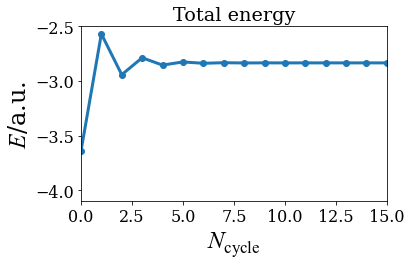

In [33]:
plt.plot(ene_traj,'o-',lw=3)
plt.title("Total energy")

plt.xlabel(r"$N_{\rm{cycle}}$",fontsize=24)
plt.ylabel(r"$E$/a.u.",fontsize=24)
figname = 'Tot_ene_He_DFT_full.png'
plt.axis([0,15,-4.1,-2.5])
plt.tight_layout()
plt.savefig(figname,dpi=300,format = 'png')
plt.show()